In [1]:
import yaml
from espei import run_espei
from pycalphad import Database, binplot, equilibrium, variables as v

In [2]:
with open('mcmc_adj-new.yaml') as fp:
    mcmc_settings = yaml.safe_load(fp)

In [4]:
import logging
import time
import numpy as np
import emcee
from espei.error_functions import calculate_zpf_error, calculate_activity_error, \
    calculate_non_equilibrium_thermochemical_probability, \
    calculate_equilibrium_thermochemical_probability, \
    calculate_Y_probability
from espei.priors import PriorSpec, build_prior_specs
from espei.utils import unpack_piecewise, optimal_parameters
from espei.error_functions.context import setup_context
from espei.optimizers.opt_base import OptimizerBase
from espei.optimizers.graph import OptNode


TRACE = 15


class EmceeOptimizer(OptimizerBase):
    """
    An optimizer using an EnsembleSampler based on Goodman and Weare [1]
    implemented in emcee [2]

    Attributes
    ----------
    scheduler : mappable
        An object implementing a `map` function
    save_interval : int
        Interval of iterations to save the tracefile and probfile.
    tracefile : str
        Filename to store the trace with NumPy.save. Array has shape
        (chains, iterations, parameters). Defaults to None.
    probfile : str
        filename to store the log probability with NumPy.save. Has shape (chains, iterations)

    References
    ----------
    [1] Goodman and Weare, Ensemble Samplers with Affine Invariance. Commun. Appl. Math. Comput. Sci. 5, 65-80 (2010).
    [2] Foreman-Mackey, Hogg, Lang, Goodman, emcee: The MCMC Hammer. Publ. Astron. Soc. Pac. 125, 306-312 (2013).
    """
    def __init__(self, dbf, scheduler=None):
        super(EmceeOptimizer, self).__init__(dbf)
        self.scheduler = scheduler
        self.save_interval = 1
        # These are set by the _fit method
        self.sampler = None
        self.tracefile = None
        self.probfile = None

    @staticmethod
    def initialize_new_chains(params, chains_per_parameter, std_deviation, deterministic=True):
        """
        Return an array of num_samples from a Gaussian distribution about each parameter.

        Parameters
        ----------
        params : ndarray
            1D array of initial parameters that will be the mean of the distribution.
        num_samples : int
            Number of chains to initialize.
        chains_per_parameter : int
            number of chains for each parameter. Must be an even integer greater or
            equal to 2. Defaults to 2.
        std_deviation : float
            Fractional standard deviation of the parameters to use for initialization.
        deterministic : bool
            True if the parameters should be generated deterministically.

        Returns
        -------
        ndarray

        Notes
        -----
        Parameters are sampled from ``normal(loc=param, scale=param*std_deviation)``.
        A parameter of zero will produce a standard deviation of zero and
        therefore only zeros will be sampled. This will break emcee's
        StretchMove for this parameter and only zeros will be selected.

        """
        logging.log(TRACE, 'Initial parameters: {}'.format(params))
        params = np.array(params)
        num_zero_params = np.nonzero(params == 0)[0].size
        if num_zero_params > 0:
            logging.warning(f"{num_zero_params} initial parameter{' is' if num_zero_params == 1 else 's are'} "
                            "initialized to zero. The ensemble of chains for zero parameters will be all initialized "
                            "to zero and all proposed values for these parameter will be zero. If possible, it's "
                            "better to make a good guess at a reasonable parameter value to start with. "
                            "Alternatively, you can start with a small value near zero and let the ensemble search "
                            "parameter space.")
        nchains = params.size * chains_per_parameter
        logging.info('Initializing {} chains with {} chains per parameter.'.format(nchains, chains_per_parameter))
        if deterministic:
            rng = np.random.RandomState(1769)
        else:
            rng = np.random.RandomState()
        # apply a Gaussian random to each parameter with std dev of std_deviation*parameter
        tiled_parameters = np.tile(params, (nchains, 1))
        chains = rng.normal(tiled_parameters, np.abs(tiled_parameters * std_deviation))
        return chains

    @staticmethod
    def initialize_chains_from_trace(restart_trace):
        tr = restart_trace
        walkers = tr[np.nonzero(tr)].reshape((tr.shape[0], -1, tr.shape[2]))[:, -1, :]
        nchains = walkers.shape[0]
        ndim = walkers.shape[1]
        initial_parameters = walkers.mean(axis=0)
        logging.info('Restarting from previous calculation with {} chains ({} per parameter).'.format(nchains, nchains / ndim))
        logging.log(TRACE, 'Means of restarting parameters are {}'.format(initial_parameters))
        logging.log(TRACE, 'Standard deviations of restarting parameters are {}'.format(walkers.std(axis=0)))
        return walkers

    @staticmethod
    def get_priors(prior, symbols, params):
        """
        Build priors for a particular set of fitting symbols and initial parameters.
        Returns a dict that should be used to update the context.

        Parameters
        ----------
        prior : dict or PriorSpec or None
            Prior to initialize. See the docs on
        symbols : list of str
            List of symbols that will be fit
        params : list of float
            List of parameter values corresponding to the symbols. These should
            be the initial parameters that the priors will be based off of.

        Returns
        -------

        """
        if isinstance(prior, dict):
            logging.info('Initializing a {} prior for the parameters.'.format(prior['name']))
        elif isinstance(prior, PriorSpec):
            logging.info('Initializing a {} prior for the parameters.'.format(prior.name))
        elif prior is None:
            prior = {'name': 'zero'}
        prior_specs = build_prior_specs(prior, params)
        rv_priors = []
        for spec, param, fit_symbol in zip(prior_specs, params, symbols):
            if isinstance(spec, PriorSpec):
                logging.debug('Initializing a {} prior for {} with parameters: {}.'.format(spec.name, fit_symbol, spec.parameters))
                rv_priors.append(spec.get_prior(param))
            elif hasattr(spec, "logpdf"):
                logging.debug('Using a user-specified prior for {}.'.format(fit_symbol))
                rv_priors.append(spec)
        return {'prior_rvs': rv_priors}

    def save_sampler_state(self):
        """
        Convenience function that saves the trace and lnprob if
        they haven't been set to None by the user.

        Requires that the sampler attribute be set.
        """
        tr = self.tracefile
        if tr is not None:
            logging.log(TRACE, 'Writing trace to {}'.format(tr))
            np.save(tr, self.sampler.chain)
        prob = self.probfile
        if prob is not None:
            logging.log(TRACE, 'Writing lnprob to {}'.format(prob))
            np.save(prob, self.sampler.lnprobability)

    def do_sampling(self, chains, iterations):
        progbar_width = 30
        logging.info('Running MCMC for {} iterations.'.format(iterations))
        try:
            for i, result in enumerate(self.sampler.sample(chains, iterations=iterations)):
                # progress bar
                if (i + 1) % self.save_interval == 0:
                    self.save_sampler_state()
                    logging.log(TRACE, 'Acceptance ratios for parameters: {}'.format(self.sampler.acceptance_fraction))
                n = int((progbar_width + 1) * float(i) / iterations)
                logging.info("\r[{0}{1}] ({2} of {3})\n".format('#' * n, ' ' * (progbar_width - n), i + 1, iterations))
            n = int((progbar_width + 1) * float(i + 1) / iterations)
            logging.info("\r[{0}{1}] ({2} of {3})\n".format('#' * n, ' ' * (progbar_width - n), i + 1, iterations))
        except KeyboardInterrupt:
            pass
        logging.info('MCMC complete.')
        self.save_sampler_state()

    def _fit(self, symbols, ds, prior=None, iterations=1000,
             chains_per_parameter=2, chain_std_deviation=0.1, deterministic=True,
             restart_trace=None, tracefile=None, probfile=None,
             mcmc_data_weights=None, approximate_equilibrium=False,
             ):
        """

        Parameters
        ----------
        symbols : list of str
        ds : PickleableTinyDB
        prior : str
            Prior to use to generate priors. Defaults to 'zero', which keeps
            backwards compatibility. Can currently choose 'normal', 'uniform',
            'triangular', or 'zero'.
        iterations : int
            Number of iterations to calculate in MCMC. Default is 1000.
        chains_per_parameter : int
            number of chains for each parameter. Must be an even integer greater
            or equal to 2. Defaults to 2.
        chain_std_deviation : float
            Standard deviation of normal for parameter initialization as a
            fraction of each parameter. Must be greater than 0. Defaults to 0.1.
        deterministic : bool
            If True, the emcee sampler will be seeded to give deterministic sampling
            draws. This will ensure that the runs with the exact same database,
            chains_per_parameter, and chain_std_deviation (or restart_trace) will
            produce exactly the same results.
        restart_trace : np.ndarray
            ndarray of the previous trace. Should have shape (chains, iterations, parameters)
        tracefile : str
            filename to store the trace with NumPy.save. Array has shape
            (chains, iterations, parameters)
        probfile : str
            filename to store the log probability with NumPy.save. Has shape (chains, iterations)
        mcmc_data_weights : dict
            Dictionary of weights for each data type, e.g. {'ZPF': 20, 'HM': 2}

        Returns
        -------
        OptNode

        """
        cbs = self.scheduler is None
        ctx = setup_context(self.dbf, ds, symbols, data_weights=mcmc_data_weights, make_callables=cbs)
        symbols_to_fit = ctx['symbols_to_fit']
        initial_guess = np.array([unpack_piecewise(self.dbf.symbols[s]) for s in symbols_to_fit])

        prior_dict = self.get_priors(prior, symbols_to_fit, initial_guess)
        ctx.update(prior_dict)
        ctx['zpf_kwargs']['approximate_equilibrium'] = approximate_equilibrium
        ctx['equilibrium_thermochemical_kwargs']['approximate_equilibrium'] = approximate_equilibrium
        # Run the initial parameters for guessing purposes:
        logging.log(TRACE, "Probability for initial parameters")
        self.predict(initial_guess, **ctx)
        if restart_trace is not None:
            chains = self.initialize_chains_from_trace(restart_trace)
            # TODO: check that the shape is valid with the existing parameters
        else:
            chains = self.initialize_new_chains(initial_guess, chains_per_parameter, chain_std_deviation, deterministic)
        sampler = emcee.EnsembleSampler(chains.shape[0], initial_guess.size, self.predict, kwargs=ctx, pool=self.scheduler)
        if deterministic:
            from espei.rstate import numpy_rstate
            sampler.random_state = numpy_rstate
            logging.info('Using a deterministic ensemble sampler.')
        self.sampler = sampler
        self.tracefile = tracefile
        self.probfile = probfile
        # Run the MCMC simulation
        self.do_sampling(chains, iterations)

        # Post process
        optimal_params = optimal_parameters(sampler.chain, sampler.lnprobability)
        logging.log(TRACE, 'Initial parameters: {}'.format(initial_guess))
        logging.log(TRACE, 'Optimal parameters: {}'.format(optimal_params))
        logging.log(TRACE, 'Change in parameters: {}'.format(np.abs(initial_guess - optimal_params) / initial_guess))
        parameters = dict(zip(symbols_to_fit, optimal_params))
        return OptNode(parameters, ds)

    @staticmethod
    def predict(params, **ctx):
        """
        Calculate lnprob = lnlike + lnprior
        """
        logging.debug('Parameters - {}'.format(params))
        # lnprior
        prior_rvs = ctx['prior_rvs']
        lnprior_multivariate = [rv.logpdf(theta) for rv, theta in zip(prior_rvs, params)]
        logging.debug('Priors: {}'.format(lnprior_multivariate))
        lnprior = np.sum(lnprior_multivariate)
        if np.isneginf(lnprior):
            # It doesn't matter what the likelihood is. We can skip calculating it to save time.
            logging.log(TRACE, 'Proposal - lnprior: {:0.4f}, lnlike: {}, lnprob: {:0.4f}'.format(lnprior, np.nan, lnprior))
            return lnprior

        # lnlike
        parameters = {param_name: param for param_name, param in zip(ctx['symbols_to_fit'], params)}
        zpf_kwargs = ctx.get('zpf_kwargs')
        activity_kwargs = ctx.get('activity_kwargs')
        Y_kwargs = ctx.get('Y_kwargs')
        non_equilibrium_thermochemical_kwargs = ctx.get('thermochemical_kwargs')
        equilibrium_thermochemical_kwargs = ctx.get('equilibrium_thermochemical_kwargs')
        starttime = time.time()
        if zpf_kwargs is not None:
            
            try:
                multi_phase_error = calculate_zpf_error(parameters=np.array(params), **zpf_kwargs)
            except (ValueError, np.linalg.LinAlgError) as e:
                raise e
                print(e)
                multi_phase_error = -np.inf
        else:
            multi_phase_error = 0
        if equilibrium_thermochemical_kwargs is not None:
            
            eq_thermochemical_prob = calculate_equilibrium_thermochemical_probability(parameters=np.array(params), **equilibrium_thermochemical_kwargs)
        else:
            eq_thermochemical_prob = 0
        if activity_kwargs is not None:
            
            actvity_error = calculate_activity_error(parameters=parameters, **activity_kwargs)
        else:
            actvity_error = 0
        if Y_kwargs is not None:
            print(parameters)
            Y_prob = calculate_Y_probability(parameters=parameters,**Y_kwargs)
        else:
            Y_prob = 0
        if non_equilibrium_thermochemical_kwargs is not None:
            
            non_eq_thermochemical_prob = calculate_non_equilibrium_thermochemical_probability(parameters=np.array(params), **non_equilibrium_thermochemical_kwargs)
        else:
            non_eq_thermochemical_prob = 0
        total_error = multi_phase_error + eq_thermochemical_prob + non_eq_thermochemical_prob + actvity_error + Y_prob
        logging.log(TRACE, f'Likelihood - {time.time() - starttime:0.2f}s - Non-equilibrium thermochemical: {non_eq_thermochemical_prob:0.3f}. Equilibrium thermochemical: {eq_thermochemical_prob:0.3f}. ZPF: {multi_phase_error:0.3f}. Activity: {actvity_error:0.3f}. Site_fractions:{Y_prob:0.3f}. Total: {total_error:0.3f}.')
        lnlike = np.array(total_error, dtype=np.float64)

        lnprob = lnprior + lnlike
        logging.log(TRACE, 'Proposal - lnprior: {:0.4f}, lnlike: {:0.4f}, lnprob: {:0.4f}'.format(lnprior, lnlike, lnprob))
        return lnprob


In [5]:
from __future__ import print_function

import os
import argparse
import logging
import multiprocessing
import sys
import json

import numpy as np
import yaml
import dask
import distributed
import sympy
import symengine
import emcee
import pycalphad
from pycalphad import Database

import espei
from espei.validation import schema
from espei import generate_parameters
from espei.utils import ImmediateClient, get_dask_config_paths, database_symbols_to_fit
from espei.datasets import DatasetError, load_datasets, recursive_glob, apply_tags, add_ideal_exclusions
# from espei.optimizers.opt_mcmc import EmceeOptimizer

TRACE = 15  # TRACE logging level|

In [6]:
parser = argparse.ArgumentParser(description=__doc__)

parser.add_argument(
    "--input", "--in",
    default=None,
    help="Input file for the run. Should be either a `YAML` or `JSON` file."
    )

parser.add_argument(
    "--check-datasets",
    metavar="PATH",
    default=None,
    help="Check input datasets at the path. Does not run ESPEI.")

parser.add_argument("--version", "-v", action='version',
                    version='%(prog)s version '+str(espei.__version__))


def log_version_info():
    """Print version info to the log"""
    logging.info('espei version       ' + str(espei.__version__))
    logging.debug('pycalphad version   ' + str(pycalphad.__version__))
    logging.debug('dask version        ' + str(dask.__version__))
    logging.debug('distributed version ' + str(distributed.__version__))
    logging.debug('sympy version       ' + str(sympy.__version__))
    logging.debug('symengine version   ' + str(symengine.__version__))
    logging.debug('emcee version       ' + str(emcee.__version__))
    logging.info("If you use ESPEI for work presented in a publication, we ask that you cite the following paper:\n    {}".format(espei.__citation__))

def get_dask_config_paths():
    candidates = dask.config.paths
    file_paths = []
    for path in candidates:
        if os.path.exists(path):
            if os.path.isdir(path):
                file_paths.extend(sorted([
                    os.path.join(path, p)
                    for p in os.listdir(path)
                    if os.path.splitext(p)[1].lower() in ('.json', '.yaml', '.yml')
                ]))
            else:
                file_paths.append(path)
    return file_paths

def _raise_dask_work_stealing():
    """
    Raise if work stealing is turn on in dask

    Raises
    -------
    ValueError

    """
    import distributed
    has_work_stealing = distributed.config['distributed']['scheduler']['work-stealing']
    if has_work_stealing:
        raise ValueError("The parameter 'work-stealing' is on in dask. Enabling this parameter causes some instability. "
            "Set 'distributed.scheduler.work-stealing: False' in your dask configuration. "
            "Configuration files on this machine are:\n{} (latter files have priority).\n"
            "See the example at http://espei.org/en/latest/installation.html#configuration for more.".format(get_dask_config_paths()))


def get_run_settings(input_dict):
    """
    Validate settings from a dict of possible input.

    Performs the following actions:
    1. Normalize (apply defaults)
    2. Validate against the schema

    Parameters
    ----------
    input_dict : dict
        Dictionary of input settings

    Returns
    -------
    dict
        Validated run settings

    Raises
    ------
    ValueError
    """
    run_settings = schema.normalized(input_dict)

    # can't have chain_std_deviation and chains_per_parameter defaults with restart_trace
    if run_settings.get('mcmc') is not None:
            if run_settings['mcmc'].get('restart_trace') is None:
                run_settings['mcmc']['chains_per_parameter'] = run_settings['mcmc'].get('chains_per_parameter', 2)
                run_settings['mcmc']['chain_std_deviation'] = run_settings['mcmc'].get('chain_std_deviation', 0.1)
    if not schema.validate(run_settings):
        raise ValueError(schema.errors)
    return run_settings


In [7]:
def run_espei(run_settings):
    """Wrapper around the ESPEI fitting procedure, taking only a settings dictionary.

    Parameters
    ----------
    run_settings : dict
        Dictionary of input settings

    Returns
    -------
    Either a Database (for generate parameters only) or a tuple of (Database, sampler)
    """
    run_settings = get_run_settings(run_settings)
    system_settings = run_settings['system']
    output_settings = run_settings['output']
    generate_parameters_settings = run_settings.get('generate_parameters')
    mcmc_settings = run_settings.get('mcmc')

    # handle verbosity
    verbosity = {
        0: logging.WARNING,
        1: logging.INFO,
        2: TRACE,
        3: logging.DEBUG
    }
    logging.basicConfig(level=verbosity[output_settings['verbosity']], filename=output_settings['logfile'])

    log_version_info()

    # load datasets and handle i/o
    logging.log(TRACE, 'Loading and checking datasets.')
    dataset_path = system_settings['datasets']
    datasets = load_datasets(sorted(recursive_glob(dataset_path, '*.json')))
    if len(datasets.all()) == 0:
        logging.warning('No datasets were found in the path {}. This should be a directory containing dataset files ending in `.json`.'.format(dataset_path))
    apply_tags(datasets, system_settings.get('tags', dict()))
    add_ideal_exclusions(datasets)
    logging.log(TRACE, 'Finished checking datasets')

    with open(system_settings['phase_models']) as fp:
        phase_models = json.load(fp)

    if generate_parameters_settings is not None:
        refdata = generate_parameters_settings['ref_state']
        excess_model = generate_parameters_settings['excess_model']
        ridge_alpha = generate_parameters_settings['ridge_alpha']
        aicc_penalty = generate_parameters_settings['aicc_penalty_factor']
        input_dbf = generate_parameters_settings.get('input_db', None)
        if input_dbf is not None:
            input_dbf = Database(input_dbf)
        dbf = generate_parameters(phase_models, datasets, refdata, excess_model,
                                  ridge_alpha=ridge_alpha, dbf=input_dbf,
                                  aicc_penalty_factor=aicc_penalty,)
        dbf.to_file(output_settings['output_db'], if_exists='overwrite')

    if mcmc_settings is not None:
        tracefile = output_settings['tracefile']
        probfile = output_settings['probfile']
        # Set trace and prob files to None if specified by the user.
        if tracefile == 'None':
            tracefile = None
        if probfile == 'None':
            probfile = None
        # check that the MCMC output files do not already exist
        # only matters if we are actually running MCMC
        if tracefile is not None and os.path.exists(tracefile):
            raise OSError('Tracefile "{}" exists and would be overwritten by a new run. Use the ``output.tracefile`` setting to set a different name.'.format(tracefile))
        if probfile is not None and os.path.exists(probfile):
            raise OSError('Probfile "{}" exists and would be overwritten by a new run. Use the ``output.probfile`` setting to set a different name.'.format(probfile))

        # scheduler setup
        if mcmc_settings['scheduler'] == 'dask':
            _raise_dask_work_stealing()  # check for work-stealing
            from distributed import LocalCluster
            cores = mcmc_settings.get('cores', multiprocessing.cpu_count())
            if (cores > multiprocessing.cpu_count()):
                cores = multiprocessing.cpu_count()
                logging.warning("The number of cores chosen is larger than available. "
                                "Defaulting to run on the {} available cores.".format(cores))
            # TODO: make dask-scheduler-verbosity a YAML input so that users can debug. Should have the same log levels as verbosity
            scheduler = LocalCluster(n_workers=cores, threads_per_worker=1, processes=True, memory_limit=0)
            client = ImmediateClient(scheduler)
            client.run(logging.basicConfig, level=verbosity[output_settings['verbosity']], filename=output_settings['logfile'])
            logging.info("Running with dask scheduler: %s [%s cores]" % (scheduler, sum(client.ncores().values())))
            try:
                bokeh_server_info = client.scheduler_info()['services']['bokeh']
                logging.info("bokeh server for dask scheduler at localhost:{}".format(bokeh_server_info))
            except KeyError:
                logging.info("Install bokeh to use the dask bokeh server.")
        elif mcmc_settings['scheduler'] == 'None' or mcmc_settings['scheduler'] is None:
            client = None
            logging.info("Not using a parallel scheduler. ESPEI is running MCMC on a single core.")
        else: # we were passed a scheduler file name
            _raise_dask_work_stealing()  # check for work-stealing
            client = ImmediateClient(scheduler_file=mcmc_settings['scheduler'])
            client.run(logging.basicConfig, level=verbosity[output_settings['verbosity']], filename=output_settings['logfile'])
            logging.info("Running with dask scheduler: %s [%s cores]" % (client.scheduler, sum(client.ncores().values())))

        # get a Database
        if mcmc_settings.get('input_db'):
            dbf = Database(mcmc_settings.get('input_db'))

        # load the restart trace if needed
        if mcmc_settings.get('restart_trace'):
            restart_trace = np.load(mcmc_settings.get('restart_trace'))
        else:
            restart_trace = None

        # load the remaining mcmc fitting parameters
        iterations = mcmc_settings.get('iterations')
        save_interval = mcmc_settings.get('save_interval')
        chains_per_parameter = mcmc_settings.get('chains_per_parameter')
        chain_std_deviation = mcmc_settings.get('chain_std_deviation')
        deterministic = mcmc_settings.get('deterministic')
        prior = mcmc_settings.get('prior')
        data_weights = mcmc_settings.get('data_weights')
        syms = mcmc_settings.get('symbols')
        approximate_equilibrium = mcmc_settings.get('approximate_equilibrium')

        # set up and run the EmceeOptimizer
        optimizer = EmceeOptimizer(dbf, scheduler=client)
        optimizer.save_interval = save_interval
        all_symbols = syms if syms is not None else database_symbols_to_fit(dbf)
        optimizer.fit(all_symbols, datasets, prior=prior, iterations=iterations,
                      chains_per_parameter=chains_per_parameter,
                      chain_std_deviation=chain_std_deviation,
                      deterministic=deterministic, restart_trace=restart_trace,
                      tracefile=tracefile, probfile=probfile,
                      mcmc_data_weights=data_weights,
                      approximate_equilibrium=approximate_equilibrium,
                      )
        optimizer.commit()

        optimizer.dbf.to_file(output_settings['output_db'], if_exists='overwrite')
        # close the scheduler, if possible
        if hasattr(client, 'close'):
                client.close()
        return optimizer.dbf, optimizer.sampler
    return dbf


In [3]:
dbf_mcmc, sampler = run_espei(mcmc_settings)

INFO:root:espei version       0.7.8+0.g3f1d679.dirty
INFO:root:If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
TRACE:root:Loading and checking datasets.
TRACE:root:Finished checking datasets
INFO:root:Not using a parallel scheduler. ESPEI is running MCMC on a single core.
INFO:root:Fitting 31 degrees of freedom.
TRACE:root:Building phase models (this may take some time)
TRACE:root:Finished building phase models (3.27s)
TRACE:root:Getting non-equilibrium thermochemical data (this may take some time)
TRACE:root:Finished getting non-equilibrium thermochemical data (0.01s)
TRACE:root:Getting equilibrium thermochemical data (this may take some time)
TRACE:root:Finished getting equilibrium thermochemi

TRACE:root:Proposal - lnprior: 0.0000, lnlike: -192201.2646, lnprob: -192201.2646
TRACE:root:Likelihood - 36.01s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -118946.227. Activity: 0.000. Site_fractions:-180380.414. Total: -299326.641.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -299326.6407, lnprob: -299326.6407
TRACE:root:Likelihood - 33.27s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -324955.689. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 32.33s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -282852.696. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 32.38s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -104562.650. Activity: 0.000. Site_fractions:-inf.

TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 31.11s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -87202.251. Activity: 0.000. Site_fractions:-80407.713. Total: -167609.963.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -167609.9632, lnprob: -167609.9632
TRACE:root:Likelihood - 29.68s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -318406.606. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 30.52s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -86344.186. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 32.57s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -247051.293. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE

TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 33.84s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -1683093.238. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 32.21s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -115349.639. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 38.80s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -119885.923. Activity: 0.000. Site_fractions:-185324.151. Total: -305210.074.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -305210.0735, lnprob: -305210.0735
TRACE:root:Likelihood - 33.86s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -65844.840. Activity: 0.000. Site_fractions:-97682.334. Total: -1

TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 28.96s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -299737.703. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 33.19s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -736287.635. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 29.50s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -557352.284. Activity: 0.000. Site_fractions:-inf. Total: -inf.
TRACE:root:Proposal - lnprior: 0.0000, lnlike: -inf, lnprob: -inf
TRACE:root:Likelihood - 38.74s - Non-equilibrium thermochemical: 0.000. Equilibrium thermochemical: 0.000. ZPF: -125603.787. Activity: 0.000. Site_fractions:-50026.958. Total: -175630.744.
TRACE:root:Proposal

In [8]:
import numpy as np
from espei.analysis import truncate_arrays
trace = np.load('trace_Y_adj3.npy')
lnprob = np.load('lnprob_Y_adj3.npy')

trace, lnprob = truncate_arrays(trace, lnprob)

(-50000.0, -40000.0)

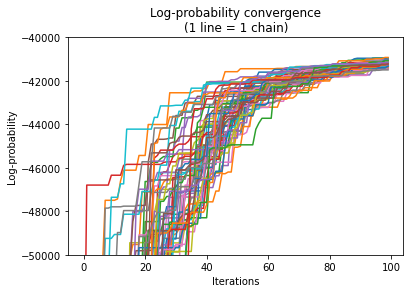

In [18]:
import matplotlib.pyplot as plt
plt.plot(lnprob.T)
plt.title('Log-probability convergence\n(1 line = 1 chain)')
plt.xlabel('Iterations')
plt.ylabel('Log-probability')
plt.ylim(-50000,-40000)

Text(0.5, 1.0, 'Parameter Convergence')

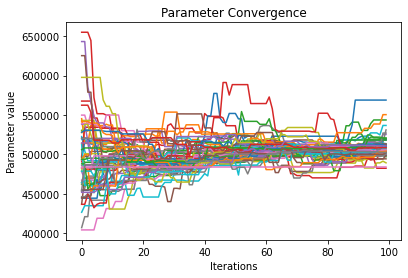

In [19]:
# index of parameter of interest within the chain
# could be looped to produce figures for all parameters
parameter_idx = 5

num_chains = trace.shape[0]
ax = plt.figure().gca()
ax.set_xlabel('Iterations')
ax.set_ylabel('Parameter value')
ax.plot(trace[..., parameter_idx].T)
ax.set_title('Parameter Convergence')

In [1]:
from scipy.stats import norm
import numpy as np
pe =norm(loc=0, scale=0.01/10).logpdf(np.array(0.5, dtype=np.float64))

In [1]:
from tests.fixtures import datasets_db
from tests.testing_data import *
from unittest import mock
from espei.optimizers.opt_mcmc import EmceeOptimizer
from espei.utils import database_symbols_to_fit
import numpy as np
import pytest
import pickle
import scipy.stats
from tinydb import where

from pycalphad import Database, Model, variables as v

from espei.paramselect import generate_parameters
from espei.error_functions import *
import os, time

import pytest
from espei.utils import PickleableTinyDB, MemoryStorage
from espei.utils import unpack_piecewise

In [2]:
NB_NI_Y_EXP

{'components': ['NB', 'NI', 'VA'],
 'phases': ['MU_PHASE'],
 'conditions': {'P': 101325,
  'T': 1273,
  'X_NB': [0.47, 0.515, 0.534, 0.55, 0.6]},
 'output': 'Y',
 'values': [[[[0.67, None, 0.85, None, 0.95, None, 0.13, None, 0.74, None],
    [0.89, None, 1.0, None, 0.89, None, 0.07, None, 0.77, None],
    [0.78, None, 0.94, None, 1.0, None, 0.1, None, 0.84, None],
    [0.85, None, 0.99, None, 1.0, None, 0.12, None, 0.81, None],
    [0.81, None, 1.0, None, 1.0, None, 0.16, None, 0.81, None]]]],
 'reference': 'Joubert2002',
 'comment': 'text'}

In [3]:
db = PickleableTinyDB(storage=MemoryStorage)

In [4]:
db.insert(NB_NI_Y_EXP)
dbf = Database(NB_NI_TDB)
error = calculate_Y_probability(dbf, ['NB','NI','VA'], list(dbf.phases.keys()), db, {}, {}, {})

[('X_NB', [0.47, 0.515, 0.534, 0.55, 0.6])]
X_NB [0.47, 0.515, 0.534, 0.55, 0.6]
[101325 101325 101325 101325 101325] [1273 1273 1273 1273 1273] [0.47  0.515 0.534 0.55  0.6  ]
cond 5 [0.47  0.515 0.534 0.55  0.6  ] [{P: 101325, T: 1273, X_NB: 0.47}, {P: 101325, T: 1273, X_NB: 0.515}, {P: 101325, T: 1273, X_NB: 0.534}, {P: 101325, T: 1273, X_NB: 0.55}, {P: 101325, T: 1273, X_NB: 0.6}]
[0.67 0.85 0.95 0.13 0.74 0.89 1.0 0.89 0.07 0.77 0.78 0.94 1.0 0.1 0.84
 0.85 0.99 1.0 0.12 0.81 0.81 1.0 1.0 0.16 0.81] [0.76204413 0.92383768 0.99999101 0.02827495 0.78677848 0.79000084
 0.954918   0.99999271 0.06851707 0.79407449 0.81007208 0.96812099
 0.99999303 0.09816106 0.7966614  0.82796874 0.97636558 0.99999319
 0.12389793 0.79795737 0.85017658 0.98362151 0.99999337 0.15485551
 0.79872189]


In [5]:
print(error)

-29908.346595859857
